#### Import dependencies

In [45]:
import os, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

try:
    from osgeo import gdal
except:
    import gdal
    
import time

try:
    import dask.array as da
    bool_dask=True
except:
    print("dask is not installed")
    bool_dask=False


dask is not installed


#### Setup input image model and output directory

In [46]:
in_img = './Data/ang20231109t131923_019_L2A_OE_main_27577724_RFL_ORT'
in_coeff_json = './Data/Nitrogen_CWM_model_file.json'
out_dir = './'

In [47]:
out_trait_img_bname = f"{out_dir}/{os.path.basename(in_img)}_{os.path.basename(in_coeff_json[:-5])}_trait_map"
print(out_trait_img_bname)

.//ang20231109t131923_019_L2A_OE_main_27577724_RFL_ORT_Nitrogen_CWM_model_file_trait_map


#### Setup constants

In [48]:
line_block_size=512
bad_range = [[300,400],[1337,1430],[1800,1960],[2450,2600]]

# gdal to numpy datatype conversion dictionary
dtype_dict = {
             gdal.GDT_Byte:np.uint8,
             gdal.GDT_Int16:np.int16,
             gdal.GDT_Int32:np.int32,
             gdal.GDT_Float32:np.float32,
             gdal.GDT_Float64:np.float64,
             gdal.GDT_UInt16:np.uint16,
             gdal.GDT_UInt32:np.uint32
}


#### Function definitions

In [49]:
def create_empty_image(new_shape, data_type, geotransform, projection, image_fn):
    rows, cols = new_shape
    driver = gdal.GetDriverByName('ENVI')
    ds = driver.Create(image_fn, cols, rows, 2, data_type,options=["INTERLEAVE=BIP"])
    ds.SetGeoTransform(geotransform)
    ds.SetProjection(projection)
    name_list=['mean','stdev']
    for iband in range(2):
        band = ds.GetRasterBand(iband+1)
        band.SetDescription(name_list[iband])
        band.SetNoDataValue(-9999)
        band = None
        
    ds = None
    
def image_memmap(in_bin, img_info_dict):
    if img_info_dict['interleave']=='BAND':
      img_shape=(img_info_dict['nbands'],img_info_dict['row'],img_info_dict['col'])
    elif img_info_dict['interleave']=='LINE':
      img_shape=(img_info_dict['row'],img_info_dict['nbands'],img_info_dict['col'])
    elif img_info_dict['interleave']=='PIXEL':
      img_shape=(img_info_dict['row'],img_info_dict['col'],img_info_dict['nbands'])

    img_mem_pt = np.memmap(in_bin,dtype=dtype_dict[img_info_dict['DataType']], mode='r',
                                  shape = img_shape)            
    return img_mem_pt

def read_image_info(in_bin, band_thres=20):

    ds = gdal.Open(in_bin)
    nbands = ds.RasterCount
    col = ds.RasterXSize
    row = ds.RasterYSize
    
    if nbands>=band_thres: # reflectance dataset
        wave_list = [ float(ds.GetRasterBand(ii+1).GetMetadata()['wavelength'])  for ii in range(nbands)]
        bname_list=None
    else:  #other dataset
        wave_list=None
        bname_list = [ ds.GetRasterBand(ii+1).GetDescription()  for ii in range(nbands)]

    md = ds.GetMetadata('IMAGE_STRUCTURE')
    
    proj_str = ds.GetProjection()
    gt = ds.GetGeoTransform()  
    img_dtype = ds.GetRasterBand(1).DataType
    
    ds=None
    return {
        'wave_list':wave_list,
        'bname_list':bname_list,
        'proj_str':proj_str,
        'interleave':md["INTERLEAVE"],
        'col':col,
        'row':row,
        'nbands':nbands,
        'DataType':img_dtype,
        'gt':gt
    }

def get_model_valie_range(model_coeffs):
    model_zero_list=np.all(model_coeffs==0,axis=0).astype(np.int8)
    diff1 = model_zero_list[1:]-model_zero_list[:-1]
    flag1=np.where(diff1==-1)[0]
    flag2= np.where(diff1==1)[0]
    
    valid_range_list=[]
    for jj in range(flag1.shape[0]):
        valid_range_list+=[[flag1[jj]+1,flag2[jj]+1]]
    
    return valid_range_list

def get_image_good_range(wavelist,bad_range):
    good_mask = np.ones(len(wavelist))
    list_array = np.array(wavelist)
    for wave_min, wave_max in bad_range:
        good_mask[(list_array>wave_min) & (list_array<wave_max)]=0
        
    return good_mask.astype(bool)

In [50]:
def process_chunk(chunk,coeffs, intercept, model_valid_range,img_good_range):
    
    # assum chunk is BIL based: n_row * n_band * n_col
    mask = (chunk[:,10,:]<-9000)
    norm_chunk = chunk / np.linalg.norm(chunk[:,img_good_range,:],axis=1)[:,None,:]

    trait_est = np.zeros((chunk.shape[0],
                          chunk.shape[2],
                          2))
                          
    trait_pred = np.zeros((chunk.shape[0],
                           coeffs.shape[0],
                          chunk.shape[2]))
                                    
    for band_start, band_end in model_valid_range:
        trait_pred += np.einsum('jlk,ml->jmk',norm_chunk[:,band_start:band_end,:],coeffs[:,band_start:band_end], optimize='optimal')
        
    trait_pred = trait_pred + intercept[None,:,None]
    trait_est[:,:,0] = trait_pred.mean(axis=1)
    trait_est[:,:,1] = trait_pred.std(ddof=1,axis=1)
    trait_est[:,:,0][mask]=-9999
    trait_est[:,:,1][mask]=-9999
    return trait_est

def process_chunk_dask(chunk0,coeffs, intercept, model_valid_range,img_good_range):
    
    # assum chunk is BIL based: n_row * n_band * n_col    
    mask = (chunk0[:,10,:]<-9000)
    
    chunk = da.from_array(chunk0, chunks=(8,chunk0.shape[1],chunk0.shape[2]))    
    
    norm_chunk = chunk / da.linalg.norm(chunk[:,img_good_range,:],axis=1)[:,None,:]

    trait_est = np.zeros((chunk.shape[0],
                          chunk.shape[2],
                          2))
                          
    trait_pred = np.zeros((chunk.shape[0],
                           coeffs.shape[0],
                          chunk.shape[2]))                    
                                    
    for band_start, band_end in model_valid_range:
        trait_pred += da.einsum('jlk,ml->jmk',norm_chunk[:,band_start:band_end,:],coeffs[:,band_start:band_end], optimize='optimal').compute()
        
    trait_pred = trait_pred + intercept[None,:,None]
    trait_est[:,:,0] = trait_pred.mean(axis=1)
    trait_est[:,:,1] = trait_pred.std(ddof=1,axis=1)
    trait_est[:,:,0][mask]=-9999
    trait_est[:,:,1][mask]=-9999
    return trait_est

In [51]:
def load_json_coeff(in_coeff_json, image_wave):
    with open(in_coeff_json) as j_file:
        coef_dict_new=json.load(j_file)
        
        model_wave_new = np.array(coef_dict_new['wavelengths'])
        model_intercept_new = np.array(coef_dict_new['intercepts'])
        model_coeff_2d_new = np.array(coef_dict_new['coefficients'])

        input_weight_0 = np.identity(image_wave.shape[0])
        interp_func_1d_new = interpolate.interp1d(image_wave,input_weight_0 , kind='nearest', axis=1, bounds_error=None, fill_value='extrapolate') # from image wavelength to model wavelength

        output_weight_new=interp_func_1d_new(model_wave_new)

        update_coeff_new  = model_coeff_2d_new@output_weight_new.T

        return update_coeff_new, model_intercept_new.ravel()
        

#### Load input image and create output image

In [53]:
img_info_dict = read_image_info(in_img)
img_good_range=get_image_good_range(img_info_dict['wave_list'],bad_range)

create_empty_image((img_info_dict['row'],img_info_dict['col']),gdal.GDT_Float32, img_info_dict['gt'], img_info_dict['proj_str'], out_trait_img_bname)

virtual_array = image_memmap(in_img, img_info_dict)

trait_img_mem_pt = np.memmap(out_trait_img_bname,dtype=dtype_dict[img_info_dict['DataType']], mode='w+',
                                  shape = (img_info_dict['row'],img_info_dict['col'],2))

#### Load trait model

In [54]:
model_coeffs, model_interception = load_json_coeff(in_coeff_json, np.array(img_info_dict['wave_list']))

model_valid_range=get_model_valie_range(model_coeffs)
print(model_valid_range)

print(f"Coefficients models: {model_coeffs.shape[0]},\nBands: {model_coeffs.shape[1]}")

[[5, 189], [211, 285], [319, 414]]
Coefficients models: 5,
Bands: 425


#### Write data to output image

In [55]:
if bool_dask:
    for row_ind_0 in range(0, img_info_dict['row'], line_block_size):
        row_start = row_ind_0
        row_end = min(row_start+line_block_size,img_info_dict['row']+1)
        trait_img_mem_pt[row_start:row_end,:,:] = process_chunk_dask(virtual_array[row_start:row_end,:,:],model_coeffs, model_interception, model_valid_range,img_good_range)
else:
    for row_ind_0 in range(0, img_info_dict['row'], line_block_size):
        row_start = row_ind_0
        row_end = min(row_start+line_block_size,img_info_dict['row']+1)
        trait_img_mem_pt[row_start:row_end,:,:] = process_chunk(virtual_array[row_start:row_end,:,:],model_coeffs, model_interception, model_valid_range,img_good_range)        

#### View the image RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-9998.6..0.85083854].


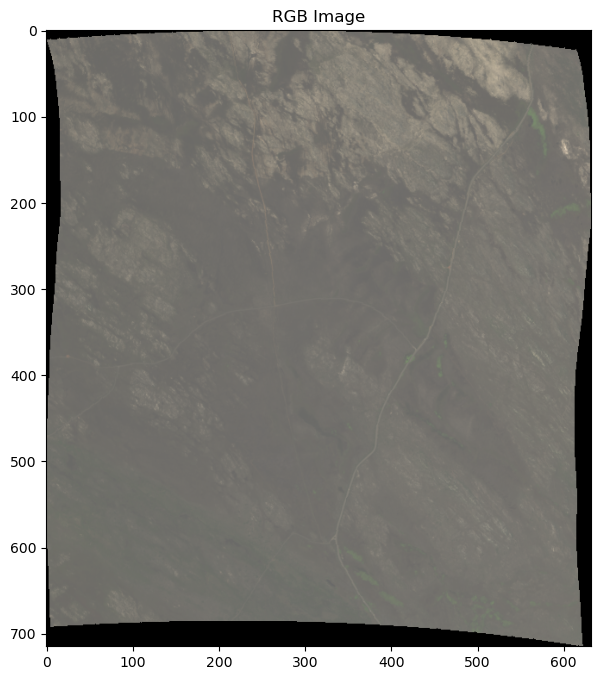

In [56]:
# Display the RGB image
plt.figure(figsize=(10, 8))
plt.imshow(np.dstack((virtual_array[:, 57, :]+0.4, virtual_array[:, 35, :]+0.4, virtual_array[:, 13, :]+0.4)))
plt.title("RGB Image")
plt.show()

#### Visualize the first band (mean) of the trait map

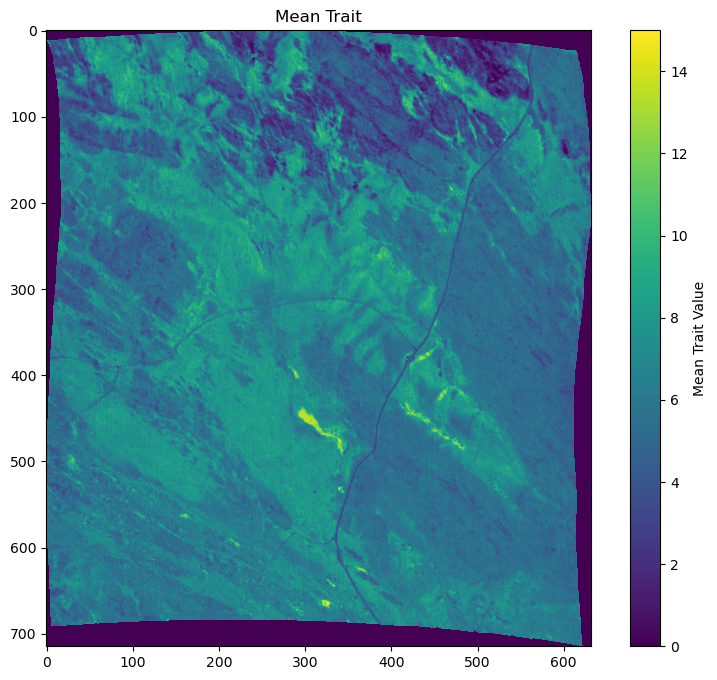

In [57]:
plt.figure(figsize=(10, 8))
plt.imshow(trait_img_mem_pt[:, :, 0], cmap='viridis',vmin=0,vmax=15)
plt.colorbar(label="Mean Trait Value")
plt.title("Mean Trait")
plt.show()

#### Visualize the second band (standard deviation) of the trait map

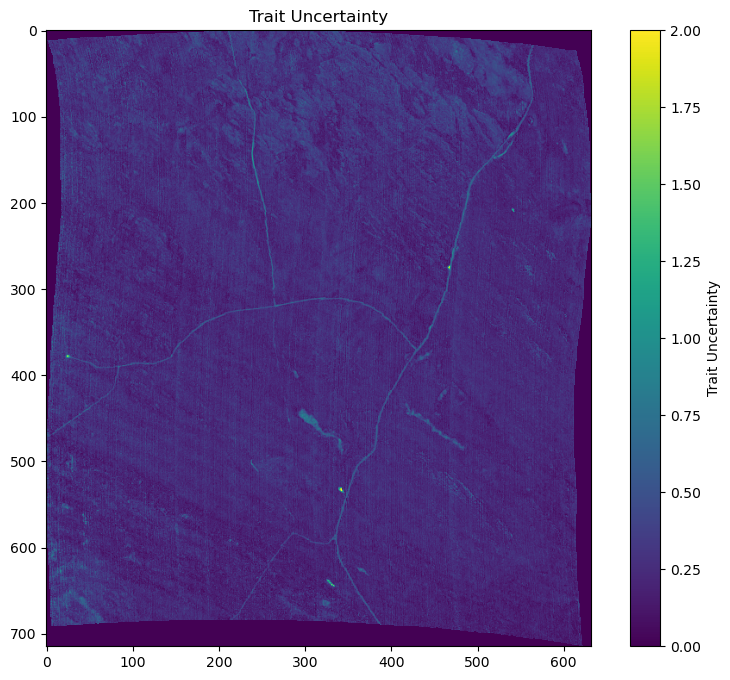

In [58]:
plt.figure(figsize=(10, 8))
plt.imshow(trait_img_mem_pt[:, :, 1], cmap='viridis',vmin=0,vmax=2)
plt.colorbar(label="Trait Uncertainty")
plt.title("Trait Uncertainty")
plt.show()

#### Close files

In [59]:
coefd_df=None
trait_img_mem_pt=None
virtual_array=None